## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

from matplotlib import pyplot as plt

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from rascil.data_models import PolarisationFrame

from rascil.processing_components import create_blockvisibility, create_skycomponent, \
    find_skycomponents, find_nearest_skycomponent, insert_skycomponent, show_image, export_image_to_fits, \
    qa_image, smooth_image, create_named_configuration, advise_wide_field, create_image_from_visibility, \
    dft_skycomponent_visibility, idft_visibility_skycomponent, create_awterm_convolutionfunction, \
    apply_bounding_box_convolutionfunction, plot_visibility

# Use workflows for imaging
from rascil.workflows.rsexecute.execution_support.rsexecute import rsexecute

from rascil.workflows import  predict_list_rsexecute_workflow, \
    invert_list_rsexecute_workflow
import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct the SKA1-LOW core configuration

In [3]:
lowcore = create_named_configuration('LOWBD2-CORE')

create_named_configuration: LOWBD2-CORE
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: 166 antennas/stations


set up rsexecute to use dask. If we are running in docker then the scheduler may be available by name.
Otherwise we just create a LocalCluster.

In [4]:
from dask.distributed import Client, LocalCluster
try:
    client = Client('scheduler:8786', timeout=10)
except OSError:
    try:
        # scheduler when run as a kubernetes cluster
        client = Client('rascil-dask-scheduler:8786', timeout=10)
    except OSError:
        client =Client(LocalCluster(processes=True, threads_per_worker=1))
print(client)

rsexecute.set_client(client=client)

Using selector: KqueueSelector
Using selector: KqueueSelector
Using selector: KqueueSelector
Using selector: KqueueSelector


/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50550 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://127.0.0.1:50551' processes=16 threads=16, memory=68.72 GB>


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [5]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_blockvisibility: created 7 times
create_blockvisibility: 97027 rows, 0.008 GB


In [6]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: (max_wavelength) Maximum wavelength 2.998 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 2.998 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 262.6 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 169.4 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
advise_wide_field: (image_fov) Image field of view 0.514 (rad) 29.4 (deg) 1.06e+05 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 0.00381 (rad) 0.218 (deg) 785 (asec)
advise_wide_field: (cellsize) Cellsize 0.00127 (rad) 0.0727 (deg) 262 (asec)
advice_wide_field: (npixels) Npixels per side = 405
advice_wide_field: (npixels2) Npixels (power of 2) per side = 512
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 512
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 512
advice_wide_field: (w_sampling_image) W sa

Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001 radians, 0.0572958 degrees
create_image_from_visibility: image shape is [1, 1, 256, 256]
Spacing in pixels = 32
Component at (240.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (4.74378292, -51.0209895)>
insert_skycomponent: Using insert method Nearest
Component at (208.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (7.66144755, -51.22149637)>
insert_skycomponent: Using insert method Nearest
Component at (176.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (10.5917361, -51.35530369)>
i

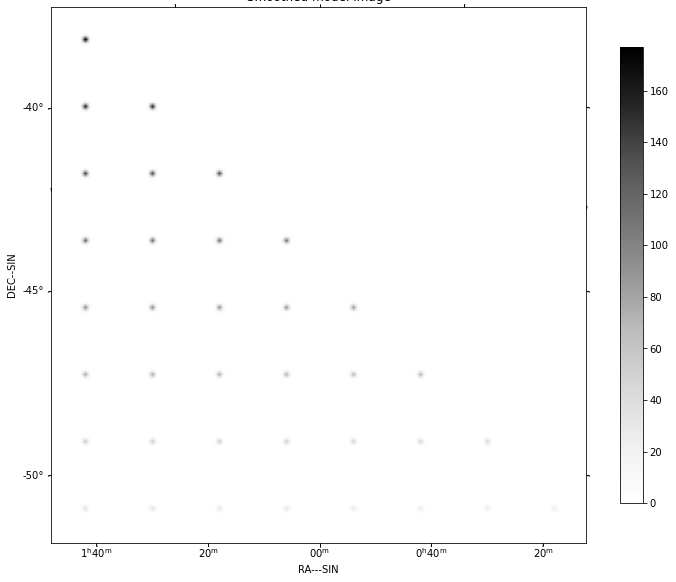

In [7]:
vt["vis"].data[...] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1, 
                                     polarisation_frame=PolarisationFrame('stokesI'))
centre = model.image_acc.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.image_acc.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.image_acc.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.image_acc.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.image_acc.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            insert_skycomponent(model, comp)

vt = dft_skycomponent_visibility(vt, original_comps)
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

In [10]:
print(model)

<xarray.Image>
Dimensions:       (frequency: 1, polarisation: 1, x: 256, y: 256)
Coordinates:
  * frequency     (frequency) float64 1e+08
  * polarisation  (polarisation) <U1 'I'
  * y             (y) float64 -0.9134 -0.9124 -0.9114 ... -0.6594 -0.6584
  * x             (x) float64 0.1338 0.1348 0.1358 ... 0.3868 0.3878 0.3888
    ra            (x, y) float64 0.4703 0.4687 0.4671 ... 0.104 0.1027 0.1015
    dec           (x, y) float64 -0.9042 -0.9044 -0.9045 ... -0.6509 -0.6508
Data variables:
    pixels        (frequency, polarisation, y, x) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    rascil_data_model:    Image
    _polarisation_frame:  stokesI
    _projection:          ('RA---SIN', 'DEC--SIN')
    spectral_type:        FREQ


Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


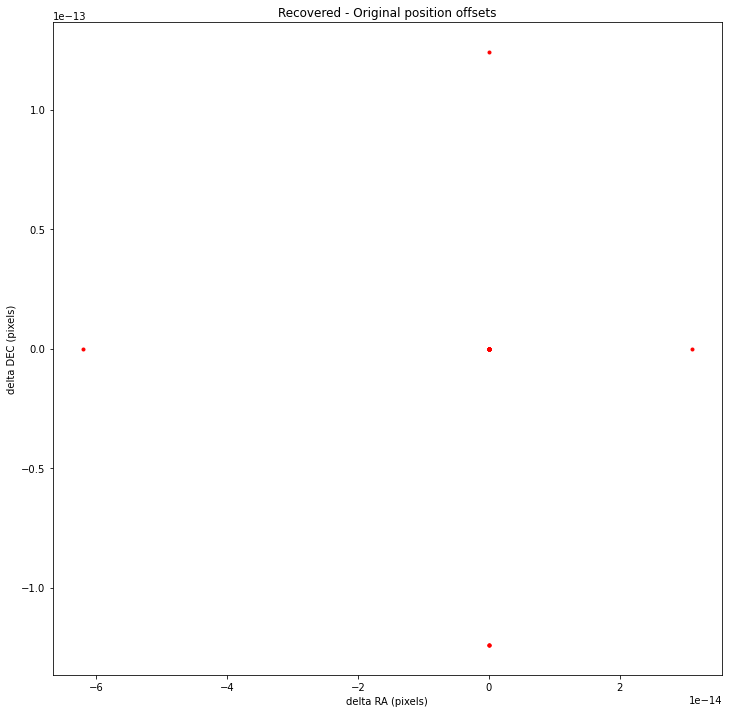

In [8]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp, sep = find_nearest_skycomponent(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.image_acc.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.image_acc.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Make the convolution function

In [9]:
wstep = 8.0
nw = int(1.1 * 800/wstep)
    
gcfcf = create_awterm_convolutionfunction(model, nw=110, wstep=8, oversampling=8, 
                                                    support=60,
                                                    use_aaf=True)
    
cf=gcfcf[1]
print(cf["pixels"].data.shape)
plt.clf()
plt.imshow(numpy.real(cf["pixels"].data[0,0,0,0,0,:,:]))
plt.title(str(numpy.max(numpy.abs(cf["pixels"].data[0,0,0,0,0,:,:]))))
plt.show()
    
cf_clipped = apply_bounding_box_convolutionfunction(cf, fractional_level=1e-3)
print(cf_clipped["pixels"].data.shape)
gcfcf_clipped=(gcfcf[0], cf_clipped)
    
plt.clf()
plt.imshow(numpy.real(cf_clipped["pixels"].data[0,0,0,0,0,:,:]))
plt.title(str(numpy.max(numpy.abs(cf_clipped["pixels"].data[0,0,0,0,0,:,:]))))
plt.show()


Setting oversampling to next greatest odd number 9


AttributeError: 'NoneType' object has no attribute 'names'

Predict the visibility using the different approaches.

In [ ]:
contexts = ['2d', 'ng', 'wprojection']

vt_list = []

for context in contexts:
    
    print('Processing context %s' % context)
   
    vtpredict_list =[create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
        weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))]
    model_list = [model]
    vtpredict_list = rsexecute.compute(vtpredict_list, sync=True)
    vtpredict_list = rsexecute.scatter(vtpredict_list)
 
    if context == 'wprojection':       
        future = predict_list_rsexecute_workflow(vtpredict_list, model_list, context='2d', gcfcf=[gcfcf_clipped])
    
    elif context == 'ng':
        future = predict_list_rsexecute_workflow(vtpredict_list, model_list, context='ng')

    else:
        future = predict_list_rsexecute_workflow(vtpredict_list, model_list, context=context)
        
    vtpredict_list = rsexecute.compute(future, sync=True)
        
    vtpredict = vtpredict_list[0]

    vt_list.append(vt)

plt.clf()

plot_visibility(vt_list, ["b", "g", "r"])
plt.show()


Make the image using the different approaches. We will evaluate the results using a number of plots:

- The error in fitted versus the radius. The ideal result is a straightline fitted: flux = DFT flux
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.

The sampling in w is set to provide 2% decorrelation at the half power point of the primary beam.


In [ ]:
contexts = ['2d', 'ng', 'wprojection']


for context in contexts:

    targetimage_list = [create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1,
                                               polarisation_frame=PolarisationFrame('stokesI'))]
    
    vt_list = [vt]


    print('Processing context %s' % context)
    if context == 'wprojection':
        future = invert_list_rsexecute_workflow(vt_list, targetimage_list, context='2d', gcfcf=[gcfcf_clipped])
    
    elif context == 'ng':
        future = invert_list_rsexecute_workflow(vt_list, targetimage_list, context=context)
        
    else:
        future = invert_list_rsexecute_workflow(vt_list, targetimage_list, context=context)
        
    result = rsexecute.compute(future, sync=True)
    targetimage = result[0][0]

    show_image(targetimage)
    plt.title(context)
    plt.show()

    print("Dirty Image %s" % qa_image(targetimage, context="imaging-fits notebook, using processor %s" % context))

    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' % (results_dir, context))
    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)

    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        idft = idft_visibility_skycomponent(vt, comp)[0][0]
        err = (comp.flux[0, 0] - idft.flux[0, 0]) / idft.flux[0, 0]
        plt.plot(distance, err, '.', color='r')
    plt.ylabel('Fractional error of image vs DFT')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.title(
        "Fractional error in %s recovered flux vs distance from phasecentre" %
        context)
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp, sep = find_nearest_skycomponent(comps[i].direction, original_comps)
            plt.plot(
                (comps[i].direction.ra.value - ocomp.direction.ra.value) /
                targetimage.wcs.wcs.cdelt[0],
                (comps[i].direction.dec.value - ocomp.direction.dec.value) /
                targetimage.wcs.wcs.cdelt[1],
                '.',
                color='r')

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % context)
        plt.show()

